In [1]:
from astropy.table import Table
import pandas as pd
from gaiaxpy import calibrate
from gaiaxpy import convert
import time
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import yaml
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units as u
from scipy.ndimage import gaussian_filter1d
import sys
from progress.bar import Bar
from tqdm.notebook import tqdm
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astropy import units as u
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import WCS
import warnings
warnings.filterwarnings("ignore")

In [2]:
def median_a(x,lw=5,lower=10000,wave=[]):
    if len(wave) > 0:
        index=np.where(wave < lower)[0]
        index2=np.where(wave >= lower)[0]
        x1=np.copy(x)
        x=x[index]
    x_n=np.zeros(len(x))
    for i in range(0, len(x)):
        if i <= lw:
            x_d=x[0:lw]
            #x_d=reject_outliers(x_d)
            x_n[i]=np.nanmean(x_d)
        if i >= len(x)-lw:
            x_d=x[len(x)-lw:len(x)]
            #x_d=reject_outliers(x_d)
            x_n[i]=np.nanmean(x_d)
        if i > lw and i < len(x)-lw:
            x_d=x[i-lw:i+lw]
            #x_d=reject_outliers(x_d)
            x_n[i]=np.nanmean(x_d) 
    if len(wave) > 0:
        x1[index]=x_n
        x1[index2]=x_n[-1]
        x_n=x1
    return x_n

In [3]:
def get_apertures(file):
    ra=[]
    dec=[]
    rad=[]
    colr=[]
    namet=[]
    l1=[]
    l2=[]
    th=[]
    typ=[]
    f=open(file,'r')
    ct=1
    for line in f:
        if not 'Region' in line and not 'fk5' in line and not 'global' in line:
            if 'circle' in line:
                data=line.replace('\n','').replace('circle(','').replace('") # color=',' , ').replace(' width=',' , ').replace(' text={',' , ').replace('}',' ')
                data=data.split(',')
                data=list(filter(None,data))
                #print(data)
                ra.extend([data[0]])
                dec.extend([data[1]])
                rad.extend([float(data[2])])
                colr.extend([data[3].replace(' ','')])
                try:
                    namet.extend([data[5].replace(' ','')])
                except:
                    namet.extend([str(int(ct))])
                l1.extend([np.nan])
                l2.extend([np.nan])
                th.extend([np.nan])    
                typ.extend(['circle'])
            if 'box' in line:
                data=line.replace('\n','').replace('box(','').replace(') # color=',' , ').replace(' width=',' , ').replace(' text={',' , ').replace('}',' ')
                data=data.split(',')
                data=list(filter(None,data))
                ra.extend([data[0]])
                dec.extend([data[1]])
                l1.extend([float(data[2].replace('"',''))])
                l2.extend([float(data[3].replace('"',''))])
                th.extend([float(data[4])])
                colr.extend([data[5].replace(' ','')])
                try:
                    namet.extend([data[7].replace(' ','')])
                except:
                    namet.extend([str(int(ct))])
                rad.extend([np.nan])    
                typ.extend(['box'])
            ct=ct+1
    ra=np.array(ra)
    dec=np.array(dec)
    rad=np.array(rad)
    colr=np.array(colr)
    namet=np.array(namet)
    typ=np.array(typ)
    l1=np.array(l1)
    l2=np.array(l2)
    th=np.array(th)
    return ra,dec,rad,l1,l2,th,colr,namet,typ

In [4]:
def extract_spec(spec,hdr,ra='',dec='',rad=1.5,pix=0.35,avgra=False):
    sky1=SkyCoord(ra+' '+dec,frame=FK5, unit=(u.hourangle,u.deg))
    val1=sky1.ra.deg
    val2=sky1.dec.deg
    wcs = WCS(hdr)
    wcs=wcs.celestial
    ypos,xpos=skycoord_to_pixel(sky1,wcs)
    print(xpos,ypos,'POS Pixel')
    val1=sky1.to_string('hmsdms')
    print(val1,'RA1,DEC1')
        
    nz,nx,ny=spec.shape
    radis=np.zeros([nx,ny])
    for i in range(0, nx):
        for j in range(0, ny):
            x_n=i-xpos
            y_n=j-ypos
            r_n=np.sqrt((y_n)**2.0+(x_n)**2.0)*pix
            radis[i,j]=r_n
    single_T=np.zeros(nz)
    nt=np.where(radis <= rad)
    for i in range(0, nz):
        tmp=spec[i,:,:]
        tmp[np.where(tmp <= 0)]=np.nan
        if avgra:
            single_T[i]=np.nanmean(tmp[nt])
        else:
            single_T[i]=np.nansum(tmp[nt])
        
    crpix=hdr["CRPIX3"]
    try:
        cdelt=hdr["CD3_3"]
    except:
        cdelt=hdr["CDELT3"]
    crval=hdr["CRVAL3"]
    wave_f=(crval+cdelt*(np.arange(nz)+1-crpix))*1e10
    
    return wave_f,single_T,xpos,ypos

In [5]:
def sycall(comand):
    import os
    linp=comand
    os.system(comand)
    
def map_ifu(expnum,redux_dir='',mjd='0000',redux_ver='0.1.1.dev0/1111/',scp=112.05,basename='lvmCFrame-NAME.fits',path_lvmcore=''):
    file=path_lvmcore+'/metrology/lvm_fiducial_fibermap.yaml'
    f=open(file,'r')
    fiber_map = yaml.safe_load(f)
    fiber_map=fiber_map['fibers']
    xp=[]
    yp=[]
    Std_id=[]
    #scp=1
    for i in range(0, len(fiber_map)):
        if 'science' in fiber_map[i][4]:
            xp.extend([float(fiber_map[i][8])*scp])
            yp.extend([float(fiber_map[i][9])*scp])
            Std_id.extend([int(fiber_map[i][0])-1])
    xp=np.array(xp)
    yp=np.array(yp)

    for i in range(0, 1):
        expn=str(int(expnum)+i).zfill(8)
        file=redux_dir+'/'+redux_ver+'/'+mjd+'/'+basename.replace('NAME',expn)
        try:
            [rss, hdr0]=fits.getdata(file,'FLUX', header=True)
        except:
            [rss, hdr0]=fits.getdata(file,0, header=True)
        #hdr1=fits.getheader(file,0)
        crpix=hdr0["CRPIX1"]
        cdelt=hdr0["CDELT1"]
        crval=hdr0["CRVAL1"]    
        rac=hdr0["POSCIRA"]
        dec=hdr0["POSCIDE"]
        if i == 0:
            rac0=rac
            dec0=dec
            nx0,ny0=rss.shape
            wave0=crval+cdelt*(np.arange(ny0)+1-crpix)
            nfib0=len(Std_id)  
            rss_f=np.zeros([nfib0,ny0])
            rss_f[0:nfib0,:]=rss[Std_id,:]
            x_ifu_V=np.zeros([nfib0,ny0])
            y_ifu_V=np.zeros([nfib0,ny0])
            for k in range(0, ny0):
                x_ifu_V[0:nfib0,k]=xp+rac*3600
                y_ifu_V[0:nfib0,k]=yp+dec*3600
        else:
            nx,ny=rss.shape  
            wave=crval+cdelt*(np.arange(ny)+1-crpix)
            for j in range(0, nfib0):
                rss_f[nfib0*i+j,:]=interp1d(wave,rss[Std_id[j],:],kind='linear',bounds_error=False)(wave0)
            for k in range(0, ny0):    
                x_ifu_V[nfib0*i:nfib0*(i+1),k]=xp+rac*3600#(rac-rac0)*3600
                y_ifu_V[nfib0*i:nfib0*(i+1),k]=yp+dec*3600#(dec-dec0)*3600   
        
    yot=(np.amax(y_ifu_V[:,0])+np.amin(y_ifu_V[:,0]))/2.0
    xot=(np.amax(x_ifu_V[:,0])+np.amin(x_ifu_V[:,0]))/2.0
    x_ifu_V=x_ifu_V-xot
    y_ifu_V=y_ifu_V-yot
    nw=len(wave0)
    ns=len(x_ifu_V[:,0])
    pix_s=18.5
    fibA=35.3
    thet=0.0
    nl=int(round((np.amax([np.amax(x_ifu_V[:,0]),-np.amin(x_ifu_V[:,0]),np.amax(y_ifu_V[:,0]),-np.amin(y_ifu_V[:,0])])+1)*2/pix_s))
    print([np.amax(x_ifu_V[:,0]),-np.amin(x_ifu_V[:,0]),np.amax(y_ifu_V[:,0]),-np.amin(y_ifu_V[:,0])])
    ifu=np.zeros([nw,nl,nl])
    ifu_e=np.ones([nw,nl,nl])
    ifu_1=np.ones([nw,nl,nl])
    ifu_m=np.zeros([nw,nl,nl])
    xo=-nl/2*pix_s
    yo=-nl/2*pix_s
    xi=xo
    xf=xo
    facto=(pix_s)**2.0/(np.pi*(fibA/2.0)**2.0)
    spec_ifu=rss_f*facto
     
    #bar = Bar('Processing', max=nl)
    pbar=tqdm(total=nl)
    int_spect=np.zeros(nw)
    for i in range(0, nl):
        xi=xf
        xf=xf+pix_s
        yi=yo
        yf=yo
        for j in range(0, nl):
            yi=yf
            yf=yf+pix_s
            spt_new=np.zeros(nw)
            Wgt=np.zeros(nw)
            for k in range(0, len(x_ifu_V[:,0])):
                Rsp=np.sqrt((x_ifu_V[k,:]-(xf+xi)/2.0)**2.0+(y_ifu_V[k,:]-(yf+yi)/2.0)**2.0)
                ntp=np.where(Rsp <= (fibA*3.5/2.0))
                Wg=np.zeros(nw)
                if len(ntp[0]) > 0:   
                    Wg[ntp]=np.exp(-(Rsp[ntp]/pix_s)**2.0/2.0)
                    spt_new[ntp]=spec_ifu[k,ntp]*Wg[ntp]+spt_new[ntp]
                Wgt=Wgt+Wg
            ntp=np.where(Wgt == 0)
            if len(ntp[0]) > 0:
                Wgt[ntp]=1
            ifu[:,j,i]=spt_new/Wgt
            int_spect=int_spect+spt_new/Wgt
        #bar.next()
        pbar.update(1)
    #bar.finish()
    pbar.close()
    
    h1=fits.PrimaryHDU(ifu)
    h2=fits.ImageHDU(ifu_e)
    h3=fits.ImageHDU(ifu_1)
    h4=fits.ImageHDU(ifu_m)
    head_list=[h1,h2,h3,h4]

    dx=0
    dy=0
    h=h1.header
    keys=list(hdr0.keys())
    for i in range(0, len(keys)):
        if not "COMMENT" in  keys[i] and not 'HISTORY' in keys[i]:
            h[keys[i]]=hdr0[keys[i]]
            h.comments[keys[i]]=hdr0.comments[keys[i]]
    #del h["CDELT1"]
    #del h["CDELT2"]
    h["NAXIS"]=3
    h["NAXIS3"]=nw 
    h["NAXIS1"]=nl
    h["NAXIS2"]=nl
    #h["NDITER"]=(len(files),'Number of dither observations')
    #h["BUNIT"]= ('1E-16 erg/s/cm^2','Unit of pixel value ' )
    #h["OBJECT"]=hdr_0[0]['OBJECT']
    h["CRVAL1"]=xot/3600.0#hdr1['CRVAL1']
    h["CD1_1"]=-np.cos(thet*np.pi/180.)*pix_s/3600.
    h["CD1_2"]=-np.sin(thet*np.pi/180.)*pix_s/3600.
    h["CRPIX1"]=nl/2+dx
    h["CTYPE1"]='RA---TAN'
    h["CRVAL2"]=yot/3600.0#hdr1['CRVAL2']
    h["CD2_1"]=-np.sin(thet*np.pi/180.)*pix_s/3600.
    h["CD2_2"]=np.cos(thet*np.pi/180.)*pix_s/3600.
    h["CRPIX2"]=nl/2+0.5+dy
    h["CTYPE2"]='DEC--TAN'
    h['CUNIT1']='deg     '                                           
    h['CUNIT2']='deg     '
    h['CDELT3']=cdelt 
    h['CRPIX3']=crpix
    h['CRVAL3']=crval
    h['CUNIT3']=('Angstrom','Units of coordinate increment and value    ')    
    h['CTYPE3']=('AWAV    ','Air wavelength (linear) ')
    h['RADECSYS']='ICRS    '
    h['SYSTEM']='FK5     '
    h['EQUINOX']=2000.00
    h['IFUCON']=(str(int(ns))+' ','NFibers')
    h['UNITS']='erg/s/cm^2'
    hlist=fits.HDUList(head_list)
    hlist.update_extend()
    basenameC='lvmCube-NAME.fits'
    file=redux_dir+'/'+redux_ver+'/'+mjd+'/'+basenameC.replace('NAME',expn)
    out_fit=file
    hlist.writeto(out_fit,overwrite=True)
    sycall('gzip -f '+out_fit)

In [15]:
map_ifu('00006573',path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60230',redux_ver='0.1.1.dev0/1111',basename='lvmFluxCFrame-NAME.fits')


[768.5509500000044, 768.5509500000044, 887.435999999987, 887.435999999987]


  0%|          | 0/96 [00:00<?, ?it/s]

In [9]:
ra_R,dec_R,rad_R,l1_R,l2_R,th_R,color,names,typ=get_apertures('HR1544.reg')
cube_file0='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60230/lvmCube2-00006570.fits.gz'
cube_file1='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60230/lvmCube1-00006570.fits.gz'
cube_file2='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60230/lvmCube-00006570.fits.gz'
[cube_data0, hdr0]=fits.getdata(cube_file0, 0, header=True)
[cube_data1, hdr1]=fits.getdata(cube_file1, 0, header=True)
[cube_data2, hdr2]=fits.getdata(cube_file2, 0, header=True)
wave0,speci0,xpos,ypos=extract_spec(cube_data0,hdr0,ra=ra_R[0],dec=dec_R[0],rad=rad_R[0],pix=18.5)
wave1,speci1,xpos,ypos=extract_spec(cube_data1,hdr1,ra=ra_R[0],dec=dec_R[0],rad=rad_R[0],pix=18.5)
wave2,speci2,xpos,ypos=extract_spec(cube_data2,hdr1,ra=ra_R[0],dec=dec_R[0],rad=rad_R[0],pix=18.5)

49.50907694114988 47.569272395583944 POS Pixel
04h50m35.981s +08d54m37.85s RA1,DEC1
49.50907694114988 47.569272395583944 POS Pixel
04h50m35.981s +08d54m37.85s RA1,DEC1
49.50907694114988 47.569272395583944 POS Pixel
04h50m35.981s +08d54m37.85s RA1,DEC1


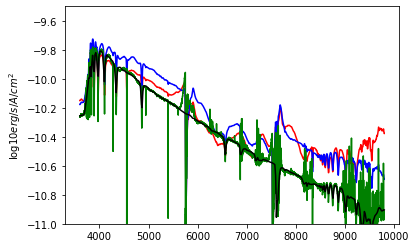

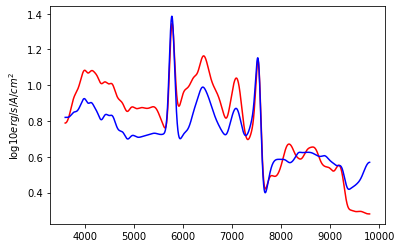

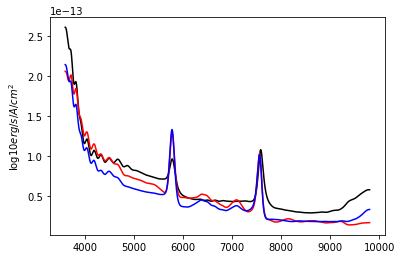

In [14]:
from astropy.io import fits

f=open('fhr1544.dat','r')
wave_f=[]
flux_f=[]
for line in f:
    data=line.replace('/n','').split(' ')
    data=list(filter(None,data))
    wave_f.extend([float(data[0])])
    flux_f.extend([float(data[1])*1e-16])
f.close()
wave_f=np.array(wave_f)
flux_f=np.array(flux_f)
wave=wave0
flux_f=interp1d(wave_f,flux_f,kind='linear',bounds_error=False)(wave)
speci1=interp1d(wave1,speci1,kind='linear',bounds_error=False)(wave)
plt.plot(wave,np.log10(speci0),color='red')
plt.plot(wave,np.log10(speci1),color='blue')
plt.plot(wave,np.log10(speci2),color='green')
plt.plot(wave,np.log10(flux_f),color='black')
plt.ylabel('log10'+'$erg/s/A/cm^2$')
plt.ylim(-11,-9.5)
plt.show()   

speci0=median_a(speci0,lw=10)
speci1=median_a(speci1,lw=10)
raw_spec0=flux_f/(speci0)
raw_spec0=gaussian_filter1d(raw_spec0, 100)
raw_spec1=flux_f/(speci1)
raw_spec1=gaussian_filter1d(raw_spec1, 100)


plt.plot(wave,raw_spec0,color='red')
plt.plot(wave,raw_spec1,color='blue')
plt.ylabel('log10'+'$erg/s/A/cm^2$')
plt.show()   

hdu_list = fits.open('SensF_v2.fits')
table_hdu = hdu_list[1]
table_data = table_hdu.data
senft=table_data.field('SENSF')
wavet=table_data.field('WAVE')

senft=interp1d(wavet,senft,kind='linear',bounds_error=False)(wave)


plt.plot(wave,senft,color='black')
plt.plot(wave,senft*raw_spec0,color='red')
plt.plot(wave,senft*raw_spec1,color='blue')
plt.ylabel('log10'+'$erg/s/A/cm^2$')

plt.show()  

flux_H=senft*raw_spec1
wave_fin=wave
from astropy.io import fits
c1 = fits.Column(name='WAVE', array=wave_fin, format='E')
c2 = fits.Column(name='SENSF', array=flux_H, format='E')
table_hdu = fits.BinTableHDU.from_columns([c1, c2])
table_hdu.writeto('SensF_v3.fits',overwrite=True)


In [22]:
ra_R,dec_R,rad_R,l1_R,l2_R,th_R,color,names,typ=get_apertures('HD60753.reg')
cube_file2='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60230/lvmCube-00006573.fits.gz'
[cube_data2, hdr2]=fits.getdata(cube_file2, 0, header=True)
wave2,speci2,xpos,ypos=extract_spec(cube_data2,hdr2,ra=ra_R[0],dec=dec_R[0],rad=rad_R[0],pix=18.5)

49.29357572835539 47.56868023506964 POS Pixel
07h33m26.157s -50d34m30.54s RA1,DEC1


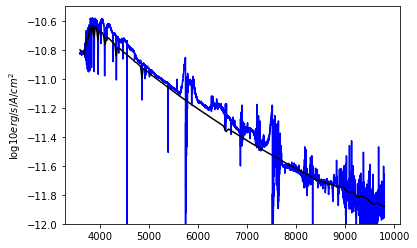

In [25]:
f=open('fhd60753.dat','r')
wave_f=[]
flux_f=[]
for line in f:
    data=line.replace('/n','').split(' ')
    data=list(filter(None,data))
    wave_f.extend([float(data[0])])
    flux_f.extend([float(data[1])*1e-16])
f.close()
wave_f=np.array(wave_f)
flux_f=np.array(flux_f)
wave=wave2
flux_f=interp1d(wave_f,flux_f,kind='linear',bounds_error=False)(wave)
speci2=interp1d(wave2,speci2,kind='linear',bounds_error=False)(wave)
#plt.plot(wave,speci2,color='blue')
plt.plot(wave,np.log10(speci2),color='blue')
plt.plot(wave,np.log10(flux_f),color='black')
plt.ylabel('log10'+'$erg/s/A/cm^2$')
plt.ylim(-12,-10.5)
plt.show()   
